### A noisy detector (Dimensionality Reduction)

Three telescopes are monitoring the same astronomical event. Their time-series output is provided  at `solutions/noisydetector.npy`. These could be the outputs of three photometry CCD cameras we still need to calibrate, or the strain channel from a gravitational-wave detectors. 

***Tasks***

1. You're observing a [Cepheid](https://en.wikipedia.org/wiki/Cepheid_variable) variable star, which is a source with an intrinsic (and presumably smooth) variability.  
2. Measure its period (that's crucial for [cosmology](https://en.wikipedia.org/wiki/Hubble%27s_law)!)
3. Estimate the error on your measurement.

(When detecting a signal, state-of-the-art gravitational-wave analysis make use of another tecnique called [matched filtering](https://en.wikipedia.org/wiki/Matched_filter) which, unfortunately, we do not have time to cover here. But PCA is used to classify instrumental artifacts, see e.g. [Powell et al 2005](https://arxiv.org/abs/1505.01299)).

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import dynesty
from dynesty import plotting as dyplot
import corner

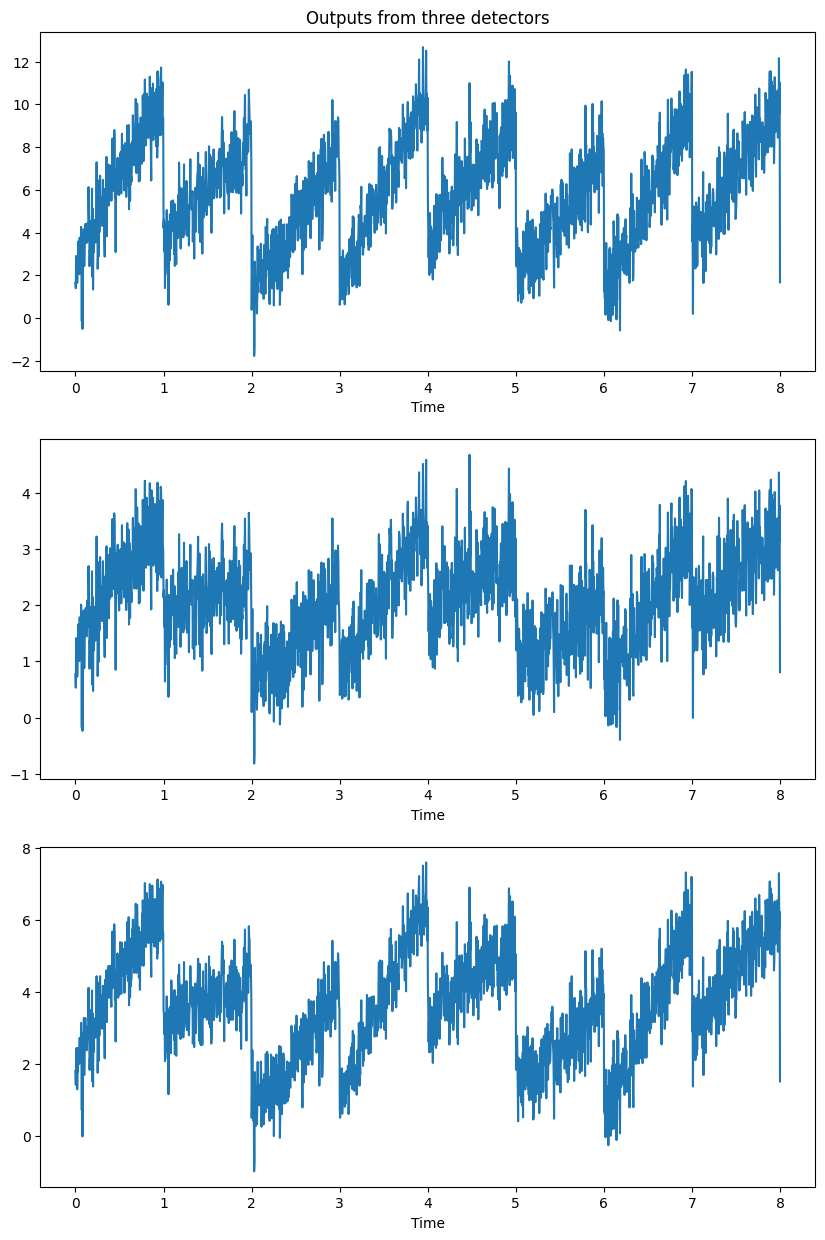

In [25]:
X=np.load('../solutions/noisydetector.npy')

time = np.linspace(0, 8, X.shape[0])

fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs,X.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('Outputs from three detectors');


In [26]:
print(X.shape)

(2000, 3)


In [27]:

n_comp = 3

In [28]:
from sklearn.decomposition import PCA, FastICA

pca = PCA(n_components=3) 
pca.fit(X) 

components = pca.transform(X) # compute the subspace projection of data
mean = pca.mean_ 
eigenvectors = pca.components_ 

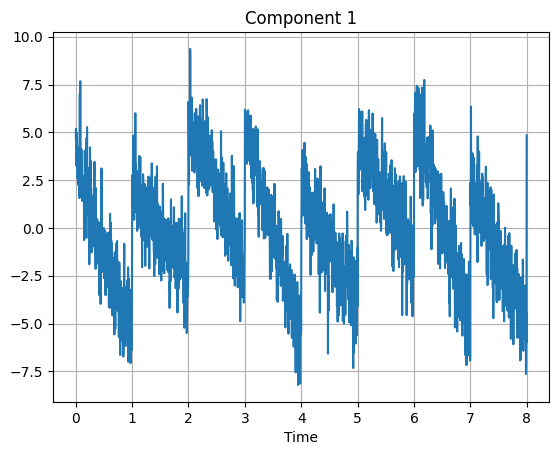

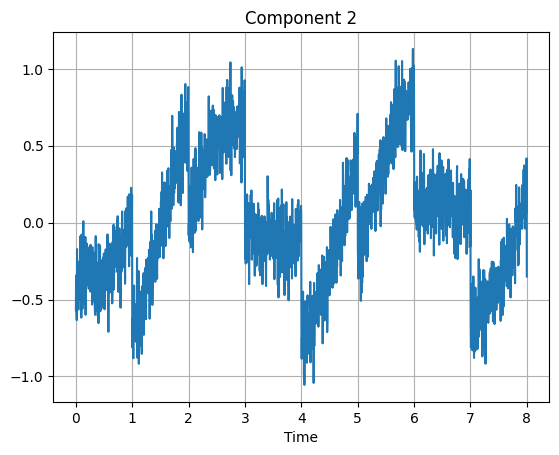

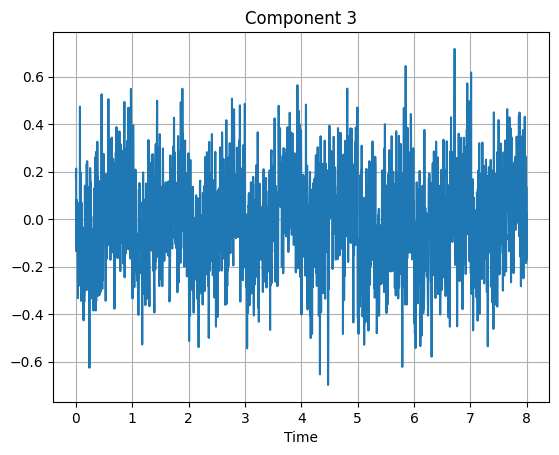

In [29]:
for i in range(n_comp):
    plt.plot(time, components[:,i])
    plt.xlabel('Time')
    plt.title('Component {}'.format(i + 1))
    plt.grid()
    plt.show()

In [30]:
ica = FastICA(n_components=3) # Now reproject to 2-D
ica.fit(X)

proj = ica.transform(X) 
components = ica.components_ 
print(components.shape)

(3, 3)


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


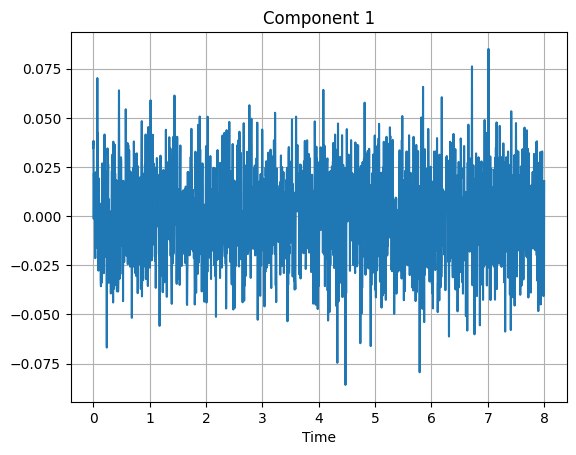

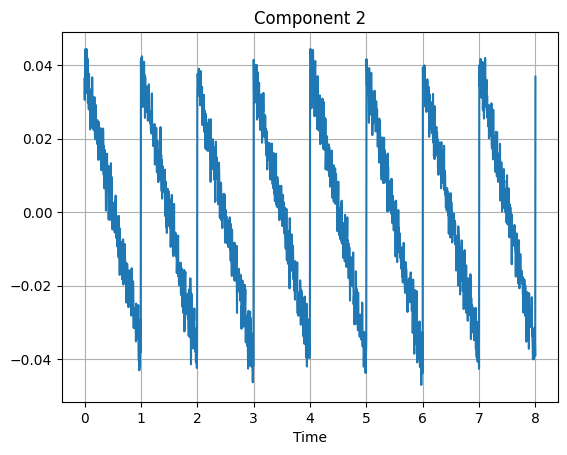

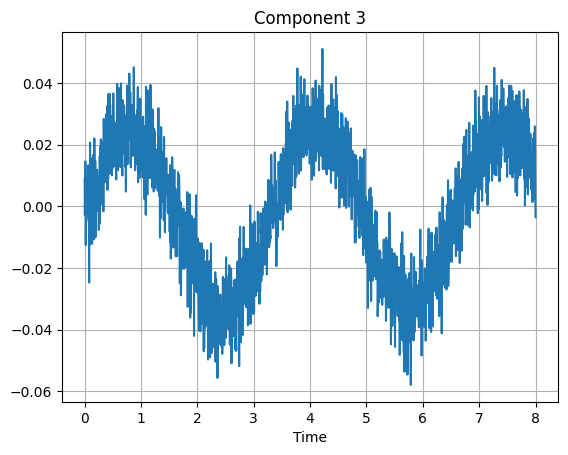

In [31]:
for i in range(n_comp):
    plt.plot(time, proj[:,i])
    plt.xlabel('Time')
    plt.title('Component {}'.format(i + 1))
    plt.grid()
    plt.show()

In [32]:
#just to stop the code and evaluate the component
#stop
component_to_evaluate = 2

In [33]:
#Estimate the error by resampling technique: bootstrap
from scipy.stats import bootstrap
n_bootraps = 1000
res = bootstrap((proj[:, component_to_evaluate],), np.std, confidence_level=0.9,
                random_state=10)

Text(0.5, 1.0, 'Bootstrap of std')

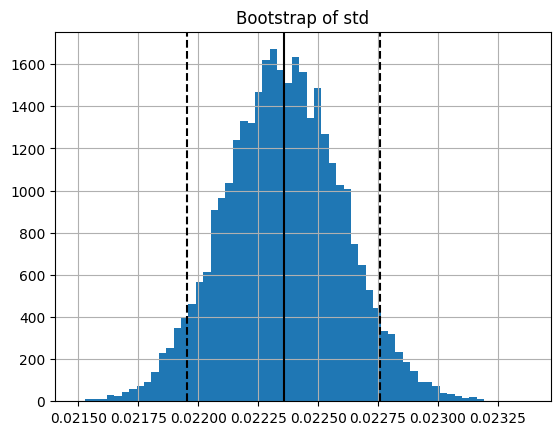

In [34]:
plt.hist(res.bootstrap_distribution, bins='fd', density=True)
plt.axvline(np.mean(res.bootstrap_distribution), color = 'black', linestyle='-', label='Mean')
plt.axvline(np.quantile(res.bootstrap_distribution, 0.95), color = 'black', linestyle='--', label='Quantiles 0.05 - 0.95')
plt.axvline(np.quantile(res.bootstrap_distribution, 0.05), color = 'black', linestyle='--')
plt.grid()
plt.title('Bootstrap of std')

In [35]:
sigma = np.mean(res.bootstrap_distribution)
print(sigma)

0.022356042750967278


## Frequentist

In [36]:
# Model : Asin(wt + phi)
# Theta : A,w,phi
def model(t, *theta):
    A, T, phi = theta
    return A*np.sin(2*np.pi/T*t + phi)

In [37]:
#Use non-linear least squares : optimize.curve_fit
params = (2., 3., 1.) #initial guess
popt,pcov = scipy.optimize.curve_fit(f=model,xdata=time, ydata=proj[:,component_to_evaluate] ,sigma=np.full_like(proj[:,component_to_evaluate], sigma), p0=params)
perr = np.sqrt(np.diag(pcov))
print('Amplitude: {} +/- {}'.format(popt[0], perr[0])) 
print('Period: {} +/- {}'.format(popt[1], perr[1]))
print('Phi: {} +/- {}'.format(popt[2], perr[2]))

Amplitude: -0.028322464388784295 +/- 0.0002914027101222546
Period: 3.3180167147139272 +/- 0.008228500707842508
Phi: 3.1802455804165537 +/- 0.021109044055472058


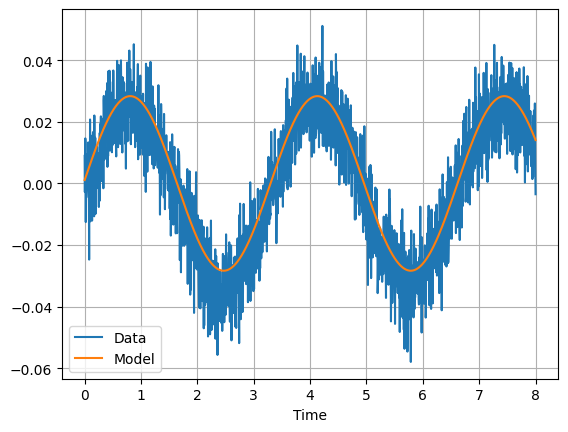

In [38]:
plt.plot(time, proj[:,component_to_evaluate], label='Data')
plt.plot(time, model(time, *popt), label='Model')
plt.grid()
plt.xlabel('Time')
plt.legend()

## Bayesian

In [39]:
#model needs thata and time inverted
def model(theta, t):
    A, T, phi = theta
    return A*np.sin((2*np.pi/T)*t + phi)

In [40]:
Amin,Amax=0,2
Tmin,Tmax=0,10
phimin,phimax=0,5



def LogLikelihood(theta):
    x, y, sigma_y = time, proj[0:,component_to_evaluate], sigma
    y_fit = model(theta, x)
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 )


def prior_transform(u):
    
    mins = [Amin,Tmin,phimin]
    maxs = [Amax,Tmax,phimax]
    
    x = mins + u* maxs-mins
    
    return x

sampler = dynesty.NestedSampler(LogLikelihood, prior_transform, ndim=3, nlive=1000) 
sampler.run_nested()
sresults = sampler.results

0it [00:00, ?it/s]

17070it [00:12, 1324.08it/s, +1000 | bound: 45 | nc: 1 | ncall: 102891 | eff(%): 17.735 | loglstar:   -inf < -173.360 <    inf | logz: -190.288 +/-  0.131 | dlogz:  0.001 >  1.009]


In [41]:
sresults = sampler.results

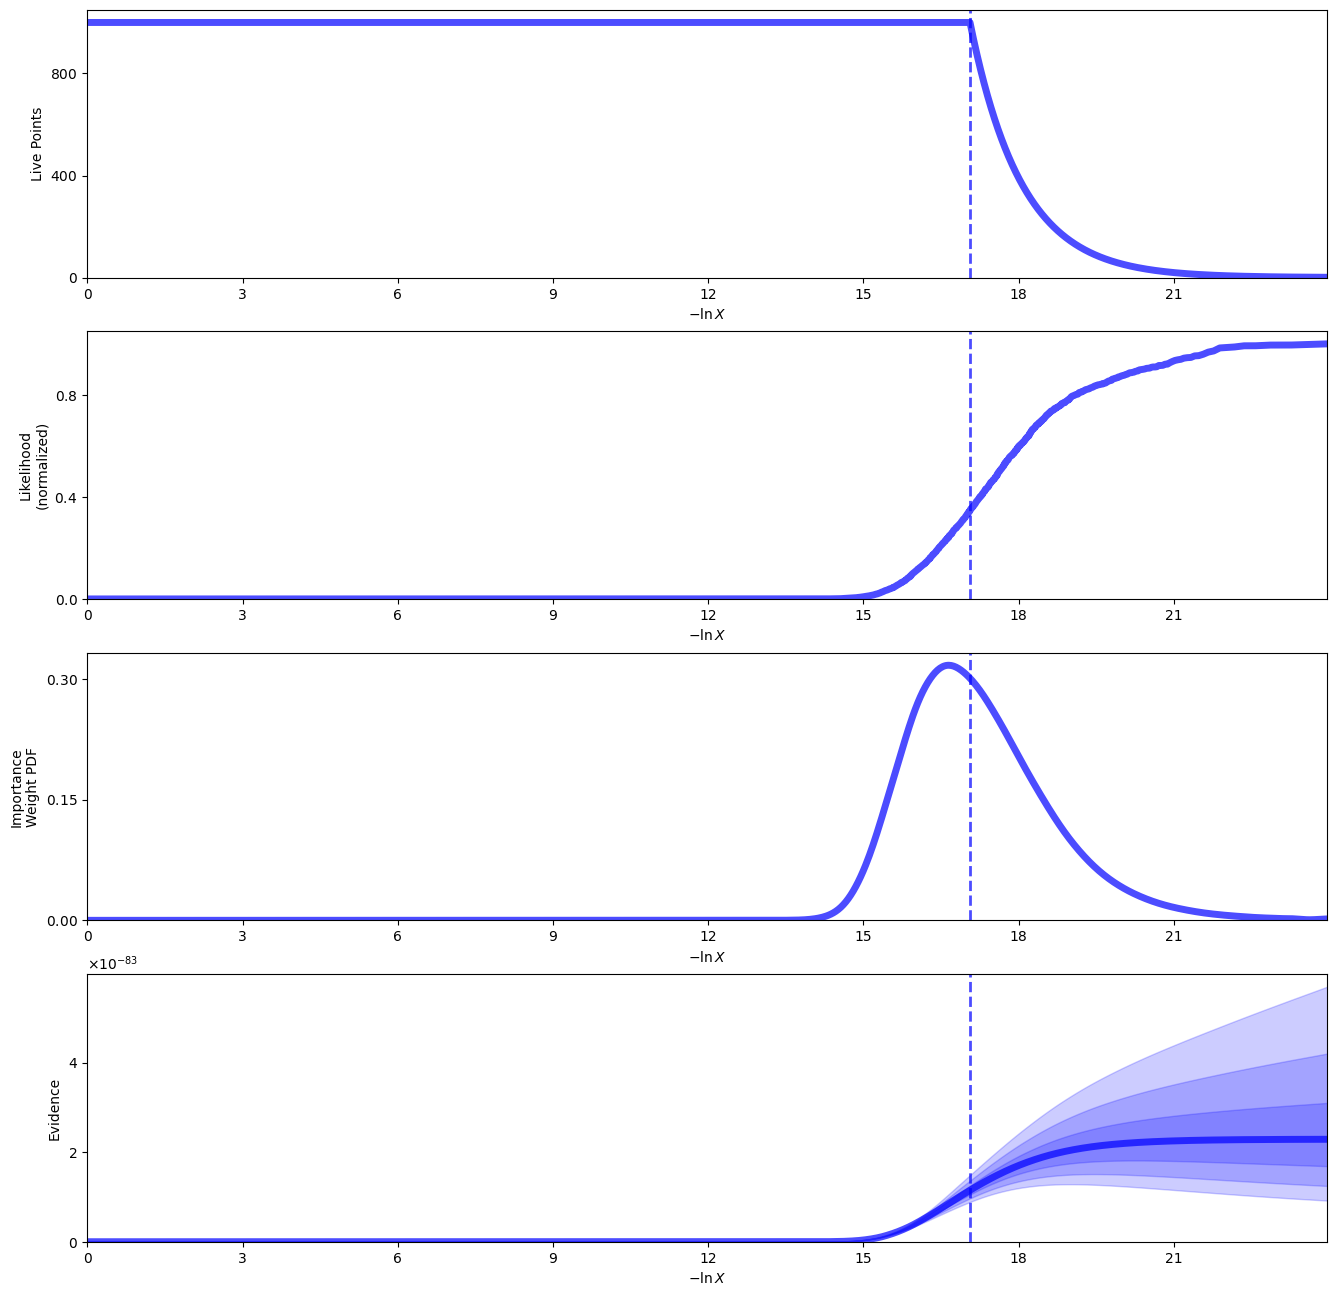

In [42]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

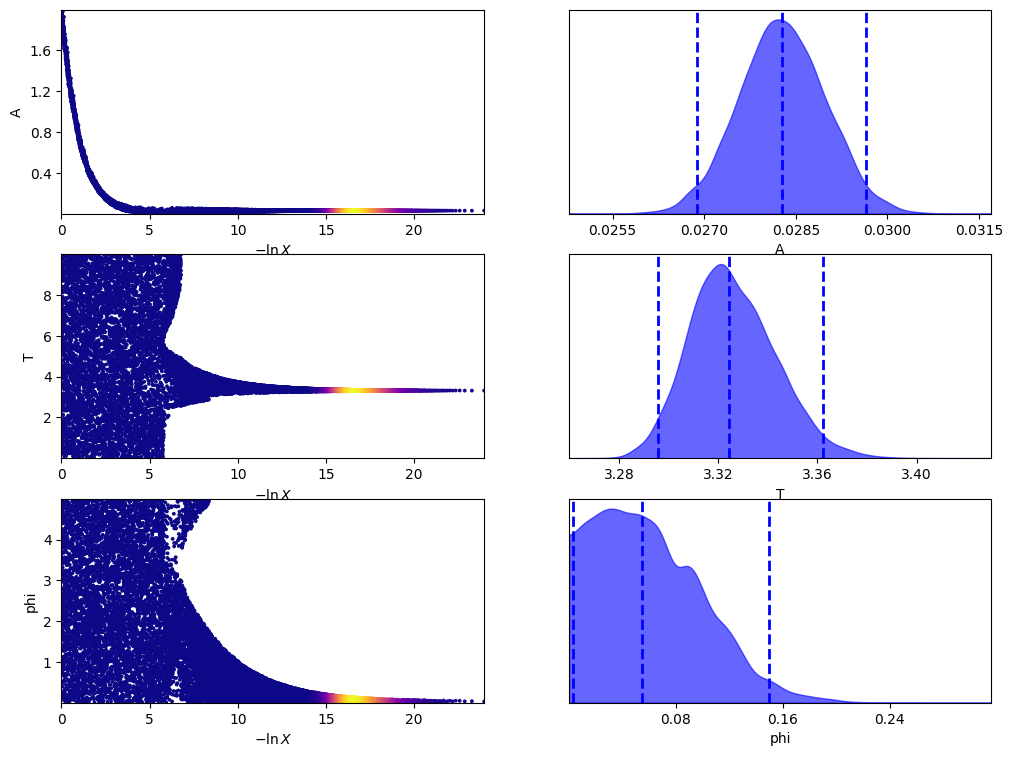

In [43]:
tfig, taxes = dyplot.traceplot(sresults, labels= ['A', 'T', 'phi'])

In [44]:
from dynesty import utils as dyfunc
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

theta_titles = ['A', 'T', 'phi']

samples_equal = dyfunc.resample_equal(samples, weights)


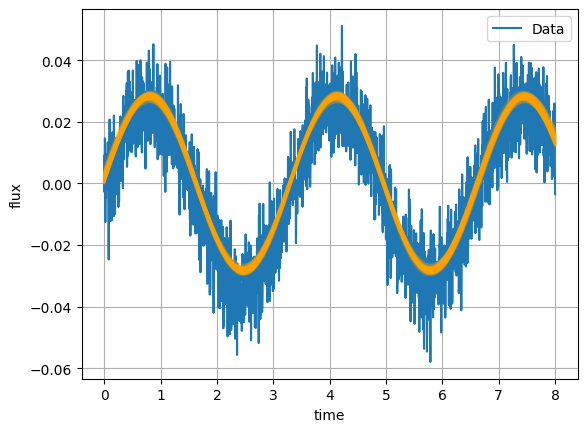

In [45]:
chosen_samples= samples_equal[np.random.choice(len(samples_equal),size=100)]

plt.plot(time, proj[:,component_to_evaluate], label='Data')
for chosen_theta in chosen_samples:
    ygrid =  model(chosen_theta, time)
    plt.plot(time,ygrid,alpha=0.2,c='orange')
    

plt.xlabel("time")
plt.ylabel("flux")
plt.grid()
plt.legend()

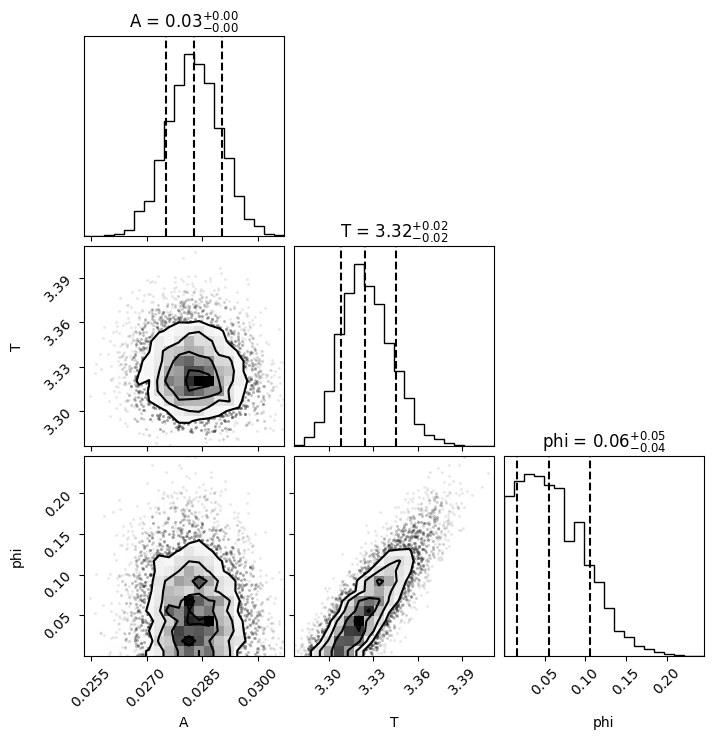

In [46]:
corner.corner(samples_equal,labels=theta_titles, quantiles=(0.14, 0.5, 0.86), show_titles=True, use_math_text=True);

In [47]:
quantiles = [dyfunc.quantile(samps, [0.1, 0.5, 0.90], weights=weights)
             for samps in samples.T]
for q,l in zip(quantiles,theta_titles):
    low,med,up=q
    print(l+"\t=\t"+str(round(med,2))+"\t+"+str(round(up-med,2))+"\t-"+str(round(med-low,2)))

A	=	0.03	+0.0	-0.0
T	=	3.32	+0.02	-0.02
phi	=	0.06	+0.06	-0.04
